# **BOOST CONVERTER SIMULATION**
By Dhonan Nabil Hibatullah, Alfarobi V12

The following circuit diagram shows a simple boost converter circuit.

![Boost Converter](assets/boost_converter.jpg "Boost Converter")
**<center>Boost Converter</center>**

The P-channel MOSFET switching is done with a PWM signal. Analyzing a boost converter circuit is a little bit more complicated than a buck converter. It is because in the ON state, there are two different circuits that run simultaneously. We will discuss about it shortly after this.

## **A. ON State (S Closed)**
As the switch S closes, there are two loops: one with the supply and the inductor on the left-hand side, and the other with the capacitor and the load on the right-hand side (please refer to the image).

**1. Dynamics on the Left**

By KVL:

$$V_s = v_L$$

$$\Longrightarrow \quad \dot{i}_L = \frac{1}{L}V_s \quad (A.1)$$

**2. Dynamics on the Right**

Similarly:

$$V_c + V_R = 0$$

$$\Longrightarrow \quad \dot{v}_C = -\frac{1}{RC}v_C \quad (A.2)$$

## **B. OFF State (S Open)**
The circuit is now all-connected. Let us write the KVL and KCL equation of the circuit.

$$V_s = v_C + v_L \quad (B.1)$$

$$i_L = i_C + i_R \quad (B.2)$$

Substitute $i_C$ and $i_R$ from the eq. $(B.2)$ with the capacitor model:

$$i_L = C\dot{v}_C + \frac{1}{R}v_C \quad (B.3)$$

Rearrange $(B.1)$ and substitute $v_C$ from $(B.3)$

$$v_C = V_s + v_L$$

$$\Longrightarrow \quad \frac{1}{RLC}V_s = \ddot{i}_L + \frac{1}{RC}\dot{i}_L + \frac{1}{LC}i_L \quad (B.4)$$

## **C. Simulation Model**
The following block diagram shows the simulation scheme.

![Boost Sim Diagram](assets/boost_sim_diagram.png "Boost Sim Diagram")
**<center>Boost Simulation Diagram</center>**

The equations used are $(A.1)$, $(A.2)$, $(B.3)$, and $(B.4)$ with $x_L = i_L$ and $x_C = v_C$. The two left blocks are evaluated in the ON state, and the remaining blocks are evaluated in the OFF state.

## **D. Simulation**
Let us demonstrate the equation $(C.3)$ with $V_s = 12.8\text{V}$, $V_D = 0\text{V}$, $T = 12.5\mu\text{s}$, $T_{on} = 0.086T$, $L = 330\mu\text{H}$, $C = 4.7\text{mF}$, and $R = 0.5\Omega$.

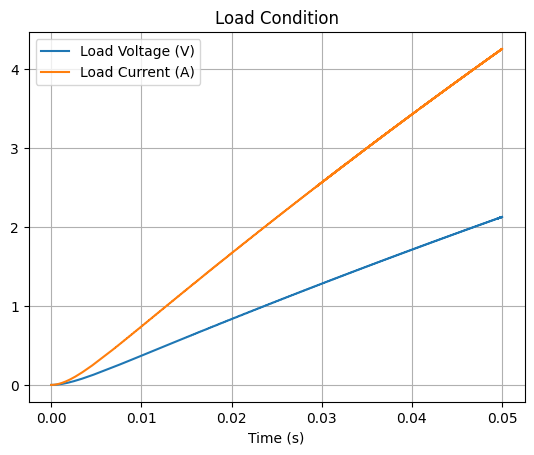

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# SIMULATION VARIABLES
t_sim       = 0.0
t_per       = 0.0
t_step      = 1e-8
sim_step    = 5000000


# MODEL VARIABLES
V_s     = 12.8
V_D     = 0.0
T_sig   = 12.5e-6
T_on    = T_sig*0.086
L       = 330e-6
C       = 4.7e-3
R       = 0.5


# SIMULATION MODEL
def on_xl(xl:np.ndarray) -> np.ndarray:
    xl_     = xl[0].item()
    xl_dot  = V_s/L

    return np.array([
        [xl_ + xl_dot*t_step],
        [xl_dot]
    ])

def on_xc(xc:np.ndarray) -> np.ndarray:
    xc_     = xc[0].item()
    xc_dot  = -(xc_/(R*C))

    return np.array([
        [xc_ + xc_dot*t_step],
        [xc_dot]
    ])

def off_xl(xl:np.ndarray) -> np.ndarray:
    A = np.array([
        [0, 1.],
        [-1./(L*C), -1./(R*C)]
    ])

    B = np.array([
        [0.],
        [1./(R*L*C)]
    ])

    u = np.array([
        [V_s]
    ])

    return xl + (A@xl + B@u)*t_step

def off_xc(xc:np.ndarray, xl:np.ndarray) -> np.ndarray:
    xl_     = xl[0].item()
    xc_     = xc[0].item()
    xc_dot  = xl_/C - (xc_/(R*C))

    return np.array([
        [xc_ + xc_dot*t_step],
        [xc_dot]
    ])

def sim_model(xl:np.ndarray, xc:np.ndarray) -> tuple:
    global t_per

    # reset time per period
    if t_per >= T_sig:
        t_per -= T_sig

    # Determine on or off
    on_state = True if t_per < T_on else False

    if on_state:
        return on_xl(xl), on_xc(xc)

    else:
        return off_xl(xl), off_xc(xc, xl)
    

# START SIMULATION
xl_state = np.array([
    [0.0],
    [0.0]
])

xc_state = np.array([
    [0.0],
    [0.0]
])

vol_arr     = [xc_state[0].item()]
amp_arr     = [xc_state[0].item()/R]
time_arr    = [t_sim]

for i in range(sim_step):
    t_sim += t_step
    t_per += t_step

    xl_state, xc_state = sim_model(xl_state, xc_state)

    vol_arr.append(xc_state[0].item())
    amp_arr.append(xc_state[0].item()/R)
    time_arr.append(t_sim)


# PLOT THE RESULT
plt.title('Load Condition')
plt.xlabel('Time (s)')
plt.plot(time_arr, vol_arr, label='Load Voltage (V)')
plt.plot(time_arr, amp_arr, label='Load Current (A)')
plt.grid()
plt.legend()
plt.show()